# Deep Evidential Regression (DER)
## Implemented in PyTorch for a CGCNN/small adsorption energy dataset.
### Overview
This notebook provides a demonstration of Deep Evidential Regression (DER), as originally published by Amini et al.
https://arxiv.org/pdf/1910.02600.pdf

Amini, A., Schwarting, W., Soleimany, A., & Rus, D. (2020). 
Deep evidential regression. 
Advances in Neural Information Processing Systems, 33, 14927-14937.

Deep Evidential Regression is demonstrated here as a proof of concept on a small adsorption energy dataset across alloy catalysts.

Much of this code was adapted from Amini et al. based on the following script:
https://github.com/aamini/evidential-deep-learning/blob/main/hello_world.py

Much of the CGCNN code in this demonstration is adapted from a demonstration by Jacques Esterhuizen.
https://scholar.google.com/citations?user=qI94iYwAAAAJ&hl=en

Additionally, this CGCNN code is based on the original proposal by Xie and Grossman.
https://arxiv.org/abs/1710.10324

Xie, T., & Grossman, J. C. (2018). Crystal graph convolutional neural networks for an accurate and interpretable prediction of material properties. Physical review letters, 120(14), 145301.

## First, we import the required modules, with the critical modules being the Pymatgen, Torch, and Torch Geometric packages

In [2]:
# For saving/loading models
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Matrix representation
import numpy as np

# Iteration
import itertools

# Pymatgen Modules
from pymatgen.core.periodic_table import Element
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.ext.matproj import MPRester

# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Pytorch/Pytorch geometric modules
import torch
import torch.nn.functional as F
import torch_geometric.data
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import CGConv

import math

# Setting figure quality
mpl.rcParams["figure.dpi"] = 300
plt.rcParams["figure.facecolor"] = "white"

## Next, we create our structural graphs, maybe the most difficult step of constructing a CGCNN. We will use the atomic number, periodic row, perioidic group, electronegativity, and Cordero radius as node features, and the average distance and connectivity as edge features.

In [3]:
def structures_to_graphs(structures, target):
    """Transform list of structure to Pytorch geometric compatible graphs.

    Args:
        structures (list): List of pymatgen structures.
        target (list): List of target properties to predict

    Returns:
        list: list of Pytorch Geometric Data objects.

    """

    Gs = []  # initialize list

    for target_index, structure in enumerate(structures):
        N_ATOMS = len(structure)
        # assign node features
        x = torch.zeros(
            (N_ATOMS, 5)
        )  # node features corresponding to atomic properties, using 5
        for i in range(N_ATOMS):
            specie = structure.species[i]
            EL_PROPS = Element(specie)
            x[i, 0] = EL_PROPS.Z  # atomic number
            x[i, 1] = EL_PROPS.group  # periodic column
            x[i, 2] = EL_PROPS.row  # periodic row
            x[i, 3] = EL_PROPS.X  # electronegativity
            x[i, 4] = (
                element(EL_PROPS.Z).covalent_radius_cordero / 100
            )  # atomic radius (in angstroms)
        # assign edge features
        edge_index = [[], []]  # edge indices specifying connectivity
        edge_attributes = (
            []
        )  # edge attributes, average distance and coordination in this case
        adjacency_matrix = np.zeros((N_ATOMS, N_ATOMS), dtype=np.float32)
        distances = np.zeros((N_ATOMS, N_ATOMS), dtype=np.float32)
        # construct adjacency and distance matrices using Pymatgen's CrystalNN module
        for i in range(N_ATOMS):
            REMOVE = []
            element_1 = (
                element(Element(structure.species[i]).Z).covalent_radius_cordero / 100
            )
            PH = CrystalNN().get_nn_info(structure, i)
            for k in PH:
                element_2 = (
                    element(
                        Element(structure.species[k["site_index"]]).Z
                    ).covalent_radius_cordero
                    / 100
                )
                DISTANCE = structure.get_distance(i, k["site_index"], k["image"])
                if DISTANCE < (element_1 + element_2 + 0.25):
                    adjacency_matrix[i, k["site_index"]] += 1
                    distances[i, k["site_index"]] += DISTANCE

        distances = (
            distances / adjacency_matrix
        )  # get mean distances using adjacency matrix

        # convert adjacency and distnace matrices to Pytorch geometric compatible objects
        for i in range(matrix.shape[0]):
            for j in range(i, matrix.shape[0]):
                # if/elif loops are so that connections are bipartite (i.e., undirected)
                if adjacency_matrix[i, j] >= 1 and i == j:
                    edge_index[0].append(i)
                    edge_index[1].append(j)
                    edge_attributes.append([adjacency_matrix[i, j], distances[i, j]])
                elif matrix[i, j] >= 1 and i != j:
                    edge_index[0].append(i)
                    edge_index[1].append(j)
                    edge_attributes.append([adjacenecy_matrix[i, j], distances[i, j]])
                    edge_index[1].append(i)
                    edge_index[0].append(j)
                    edge_attributes.append([adjacenecy_matrix[i, j], distances[i, j]])
        edge_attributes = torch.tensor(
            edge_attributes, dtype=torch.float32
        )  # convert list to tensor
        edge_index = torch.tensor(edge_index, dtype=int)  # convert list to tensor

        # create graph object and append to Gs
        Gs.append(
            Data(
                x=x,
                edge_attr=edge_attributes,
                edge_index=edge_index,
                y=torch.tensor([[target[target_index]]]),
            )
        )

    return Gs

## Let's test our code on some alloy structure data from the Materials Project. This step is somewhat time consuming, so graph data is pre-pickled (i.e., saved to a file) using the commented out code.

In [4]:
"""
# Obtain structures from materials project and turn into graphs

METALS = ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Y', 'Zr', 'Nb',
          'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Hf', 'Ta','W', 'Re', 'Os',  'Ir', 'Pt', 'Au']

# Pulling data from the Materials Project requires an API Key to connect with the database.
# An API key can be obtained by registering an account on the Materials Project Website.
# https://materialsproject.org/
mpr = MPRester('INSERT_YOUR_OWN_API_KEY_HERE')
STRUCTURES = []
ENTRY_IDS = []
ENERGIES = []

for A, B in itertools.combinations(METALS, 2):

    entries = mpr.get_entries_in_chemsys([A, B], inc_structure=True)
    for entry in entries:
        if entry.as_dict()['entry_id'] not in ENTRY_IDS:
            if len(entry.structure) < 50:
                STRUCTURES.append(entry.structure)
                ENTRY_IDS.append(entry.as_dict()['entry_id'])
                ENERGIES.append(entry.as_dict()['energy']/len(entry.structure))

data = structures_to_graphs(STRUCTURES, ENERGIES)

with open('alloy_data.pckl', 'wb') as structure:
    ab3 = pickle.dump(data, structure)
"""

"\n# Obtain structures from materials project and turn into graphs\n\nMETALS = ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Y', 'Zr', 'Nb',\n          'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Hf', 'Ta','W', 'Re', 'Os',  'Ir', 'Pt', 'Au']\n\n# Pulling data from the Materials Project requires an API Key to connect with the database.\n# An API key can be obtained by registering an account on the Materials Project Website.\n# https://materialsproject.org/\nmpr = MPRester('INSERT_YOUR_OWN_API_KEY_HERE')\nSTRUCTURES = []\nENTRY_IDS = []\nENERGIES = []\n\nfor A, B in itertools.combinations(METALS, 2):\n\n    entries = mpr.get_entries_in_chemsys([A, B], inc_structure=True)\n    for entry in entries:\n        if entry.as_dict()['entry_id'] not in ENTRY_IDS:\n            if len(entry.structure) < 50:\n                STRUCTURES.append(entry.structure)\n                ENTRY_IDS.append(entry.as_dict()['entry_id'])\n                ENERGIES.append(entry.as_dict()['energy']/len(entry.structur

In [5]:
# load pre-transformed graphs
with open("alloy_data.pckl", "rb") as structure:
    data = pickle.load(structure)

## Next, we define our CGCNN model for deep evidential regression. We will use a model with three convolutional layers and four fully connected layers, but note that the CGCNN architecture is very flexible, and there are many possible model architectures.

In [6]:
# One of the steps to implementing DER is creating a custom output layer for the model
# This custom output layer has the same weight/bias initialization of a standard dense, linear PyTorch layer
# Except, it calculates evidential distribution parameters
class DenseNormalGamma(torch.nn.Module):
    # Default output size is 4 because there are 4 parameters to the evidential distribution
    def __init__(self, inputSize, outputSize=4):
        super().__init__()
        self.inputSize, self.outputSize = inputSize, outputSize

        # Neural network weight tensor
        weights = torch.Tensor(inputSize, outputSize)

        # torch.nn.Parameter() converts a tensort to a special type of tensor that can be used as a module parameter
        self.weights = torch.nn.Parameter(weights)

        # Bias tensor
        bias = torch.Tensor(outputSize)

        # Turn the bias into a module parameter as well
        self.bias = torch.nn.Parameter(bias)

        # Initializing the weights and biases
        # Weight initialization (equivalent to standard dense, linear PyTorch layer)
        torch.nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))
        fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / np.sqrt(fan_in)

        # Bias initialization (equivalent to standard dense, linear PyTorch layer)
        torch.nn.init.uniform_(self.bias, -bound, bound)

    # Define a new function called evidence()
    # All this function does is perform SoftPlus on the evidential distribution parameters.
    # This has the effect of ensuring all parameters are positive at all times
    def evidence(self, x):
        return torch.nn.functional.softplus(x)

    # Now a new function needs to be defined to describe how data is forward-passed through the model
    def forward(self, x):
        # Multiply the incoming data by the neural network edge weights
        self.weightMultipliedData = torch.matmul(x, self.weights)
        # Add the neural network node biases
        self.biasesAdded = torch.add(self.weightMultipliedData, self.bias)

        # Split the output layer (which contains evidential hyperdist. parameters)
        # into individual evidential distribution parameters
        mu, logv, logalpha, logbeta = torch.split(self.biasesAdded, 1, dim=1)

        # Ensure positive values to the hyperdistribution parameters
        v = self.evidence(logv)
        logAlphaEvidence = self.evidence(logalpha)
        alpha = logAlphaEvidence + 1
        beta = self.evidence(logbeta)

        # Return the overall output of the positive-ensured hyperdistr. parameters.
        # This is our forward pass result.
        return torch.cat([mu, v, alpha, beta], dim=1)


class CGCNN(torch.nn.Module):
    """CGCNN model w/ two convolutional layers and four fully connected layers."""

    def __init__(self, device="cpu"):
        super().__init__()
        self.conv1 = CGConv(5, dim=2)
        self.conv2 = CGConv(5, dim=2)
        self.linear_1 = torch.nn.Linear(5, 512)
        self.linear_2 = torch.nn.Linear(512, 512)
        self.dropout_1 = torch.nn.Dropout(p=0)
        # We put the custom deep evidential regression layer here.
        self.DenseNormalGamma = DenseNormalGamma(inputSize=512)

    def forward(self, data_sample):
        # get attributes
        x, edge_index, edge_attr = (
            data_sample.x.float(),
            data_sample.edge_index,
            data_sample.edge_attr.float(),
        )
        # convolutional layers
        x = self.conv1(x=x, edge_index=edge_index, edge_attr=edge_attr)
        x = self.conv2(x, edge_index=edge_index, edge_attr=edge_attr)
        # apply pooling and normalize
        x_new = torch.zeros((len(data_sample.y), 5), dtype=torch.float32)
        for i in range(len(data_sample.y)):
            x_new[i, :] = torch.sum(x[data_sample.batch == i, :], 0)
        x = x_new.float()

        if device != "cpu":
            x = F.normalize(x, dim=1).to(device)
        else:
            x = F.normalize(x, dim=1)

        # fully connected layers
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.dropout_1(x)

        # The custom evidential layer (i.e., DenseNormalGamma) calculates the evidential distribution
        # hyperparameters only at the very end of the model. So, we return the output from this layer
        # as the final model output.
        return self.DenseNormalGamma(x)

In [7]:
# Custom function for calculating the negative log likelihood of the evidential loss function
def NIG_NLL(y, gamma, v, alpha, beta, reduce=True):
    twoBlambda = 2 * beta * (1 + v)

    nll = (
        0.5 * torch.log(np.pi / v)
        - alpha * torch.log(twoBlambda)
        + (alpha + 0.5) * torch.log(v * (y - gamma) ** 2 + twoBlambda)
        + torch.lgamma(alpha)
        - torch.lgamma(alpha + 0.5)
    )

    return torch.mean(nll) if reduce else nll


# Custom function for calculating the regularizer term of the evidential loss function
def NIG_Reg(y, gamma, v, alpha, beta, reduce=True):
    # Get the predictive error
    error = torch.abs(y - gamma)

    evidence = 2 * v + (alpha)
    reg = error * evidence

    return torch.mean(reg) if reduce else reg


# One of the steps to implementing DER is to define a custom loss function for the neural network
# This is done here.
def EvidentialRegression(yTrue, evidentialOutput, coeff=1.0):
    # Get the evidential distribution parameters from the model output
    gamma, v, alpha, beta = torch.split(evidentialOutput, 1, dim=1)
    # Calculate the negative log likelihood term of the evidential loss function
    loss_nll = NIG_NLL(yTrue, gamma, v, alpha, beta, reduce=True)
    # Calculate the regularizer term (see original paper)
    loss_reg = NIG_Reg(yTrue, gamma, v, alpha, beta, reduce=True)

    return loss_nll + (coeff * loss_reg)

## We can train our model using the Adam optimizer, a gradient-based optimization algorithm, and the evidential regression loss function.

CGCNN(
  (conv1): CGConv(5, dim=2)
  (conv2): CGConv(5, dim=2)
  (linear_1): Linear(in_features=5, out_features=512, bias=True)
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (dropout_1): Dropout(p=0, inplace=False)
  (DenseNormalGamma): DenseNormalGamma()
)


/home/cameron/anaconda3/envs/ocp-models/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0| Average batch Evidential Loss: 2.504622538558772
Epoch: 1| Average batch Evidential Loss: 2.1620897572548663
Epoch: 2| Average batch Evidential Loss: 2.094099216773862
Epoch: 3| Average batch Evidential Loss: 2.0636532912488845
Epoch: 4| Average batch Evidential Loss: 2.0774511978274486
Epoch: 5| Average batch Evidential Loss: 2.059324435523299
Epoch: 6| Average batch Evidential Loss: 2.0467961977739804
Epoch: 7| Average batch Evidential Loss: 2.0158073120429867
Epoch: 8| Average batch Evidential Loss: 1.9659920158933422
Epoch: 9| Average batch Evidential Loss: 1.9327038262711196
Epoch: 10| Average batch Evidential Loss: 1.8858301991322002
Epoch: 11| Average batch Evidential Loss: 1.8099580094462535
Epoch: 12| Average batch Evidential Loss: 1.7684821388760552
Epoch: 13| Average batch Evidential Loss: 1.7293028958508225
Epoch: 14| Average batch Evidential Loss: 1.6984651191312758
Epoch: 15| Average batch Evidential Loss: 1.6637657871011828
Epoch: 16| Average batch Evidential L

Epoch: 135| Average batch Evidential Loss: 0.6700707023169418
Epoch: 136| Average batch Evidential Loss: 0.6612008335450511
Epoch: 137| Average batch Evidential Loss: 0.645260257005203
Epoch: 138| Average batch Evidential Loss: 0.627030735652222
Epoch: 139| Average batch Evidential Loss: 0.6795306208803028
Epoch: 140| Average batch Evidential Loss: 0.6112243111634658
Epoch: 141| Average batch Evidential Loss: 0.5748850785989742
Epoch: 142| Average batch Evidential Loss: 0.5847541551395762
Epoch: 143| Average batch Evidential Loss: 0.6002946925334266
Epoch: 144| Average batch Evidential Loss: 0.611512368697612
Epoch: 145| Average batch Evidential Loss: 0.6448078201320327
Epoch: 146| Average batch Evidential Loss: 0.605794936723885
Epoch: 147| Average batch Evidential Loss: 0.5624944832725604
Epoch: 148| Average batch Evidential Loss: 0.6211131506095655
Epoch: 149| Average batch Evidential Loss: 0.5815683266178506
Epoch: 150| Average batch Evidential Loss: 0.5978221181077791
Epoch: 151| 

Epoch: 267| Average batch Evidential Loss: 0.3194872354745071
Epoch: 268| Average batch Evidential Loss: 0.2966227900126155
Epoch: 269| Average batch Evidential Loss: 0.2803238299675286
Epoch: 270| Average batch Evidential Loss: 0.32414983103021244
Epoch: 271| Average batch Evidential Loss: 0.27754477585559006
Epoch: 272| Average batch Evidential Loss: 0.34018038026988506
Epoch: 273| Average batch Evidential Loss: 0.3341855975707657
Epoch: 274| Average batch Evidential Loss: 0.3099227673679468
Epoch: 275| Average batch Evidential Loss: 0.3016436576736389
Epoch: 276| Average batch Evidential Loss: 0.2937069376777919
Epoch: 277| Average batch Evidential Loss: 0.5071124827840411
Epoch: 278| Average batch Evidential Loss: 0.2860493759288773
Epoch: 279| Average batch Evidential Loss: 0.262778843600364
Epoch: 280| Average batch Evidential Loss: 0.25293246822691234
Epoch: 281| Average batch Evidential Loss: 0.3091320056147629
Epoch: 282| Average batch Evidential Loss: 0.46653672919578115
Epoc

Epoch: 398| Average batch Evidential Loss: 0.14790202005476247
Epoch: 399| Average batch Evidential Loss: 0.1994046612841184
Epoch: 400| Average batch Evidential Loss: 0.1496373752101523
Epoch: 401| Average batch Evidential Loss: 0.1289264074274812
Epoch: 402| Average batch Evidential Loss: 0.2670834048910708
Epoch: 403| Average batch Evidential Loss: 0.2713588905352794
Epoch: 404| Average batch Evidential Loss: 0.3196097418253661
Epoch: 405| Average batch Evidential Loss: 0.4275569515073764
Epoch: 406| Average batch Evidential Loss: 0.14035118129257051
Epoch: 407| Average batch Evidential Loss: 0.314151647164807
Epoch: 408| Average batch Evidential Loss: 0.12739685673236115
Epoch: 409| Average batch Evidential Loss: 0.1902341786695675
Epoch: 410| Average batch Evidential Loss: 0.353586550962302
Epoch: 411| Average batch Evidential Loss: 0.13843770344268347
Epoch: 412| Average batch Evidential Loss: 0.1556830969333771
Epoch: 413| Average batch Evidential Loss: 0.14245462045836887
Epoch

Text(0, 0.5, 'Average batch Evidential Loss ((eV/atom)$^2$)')

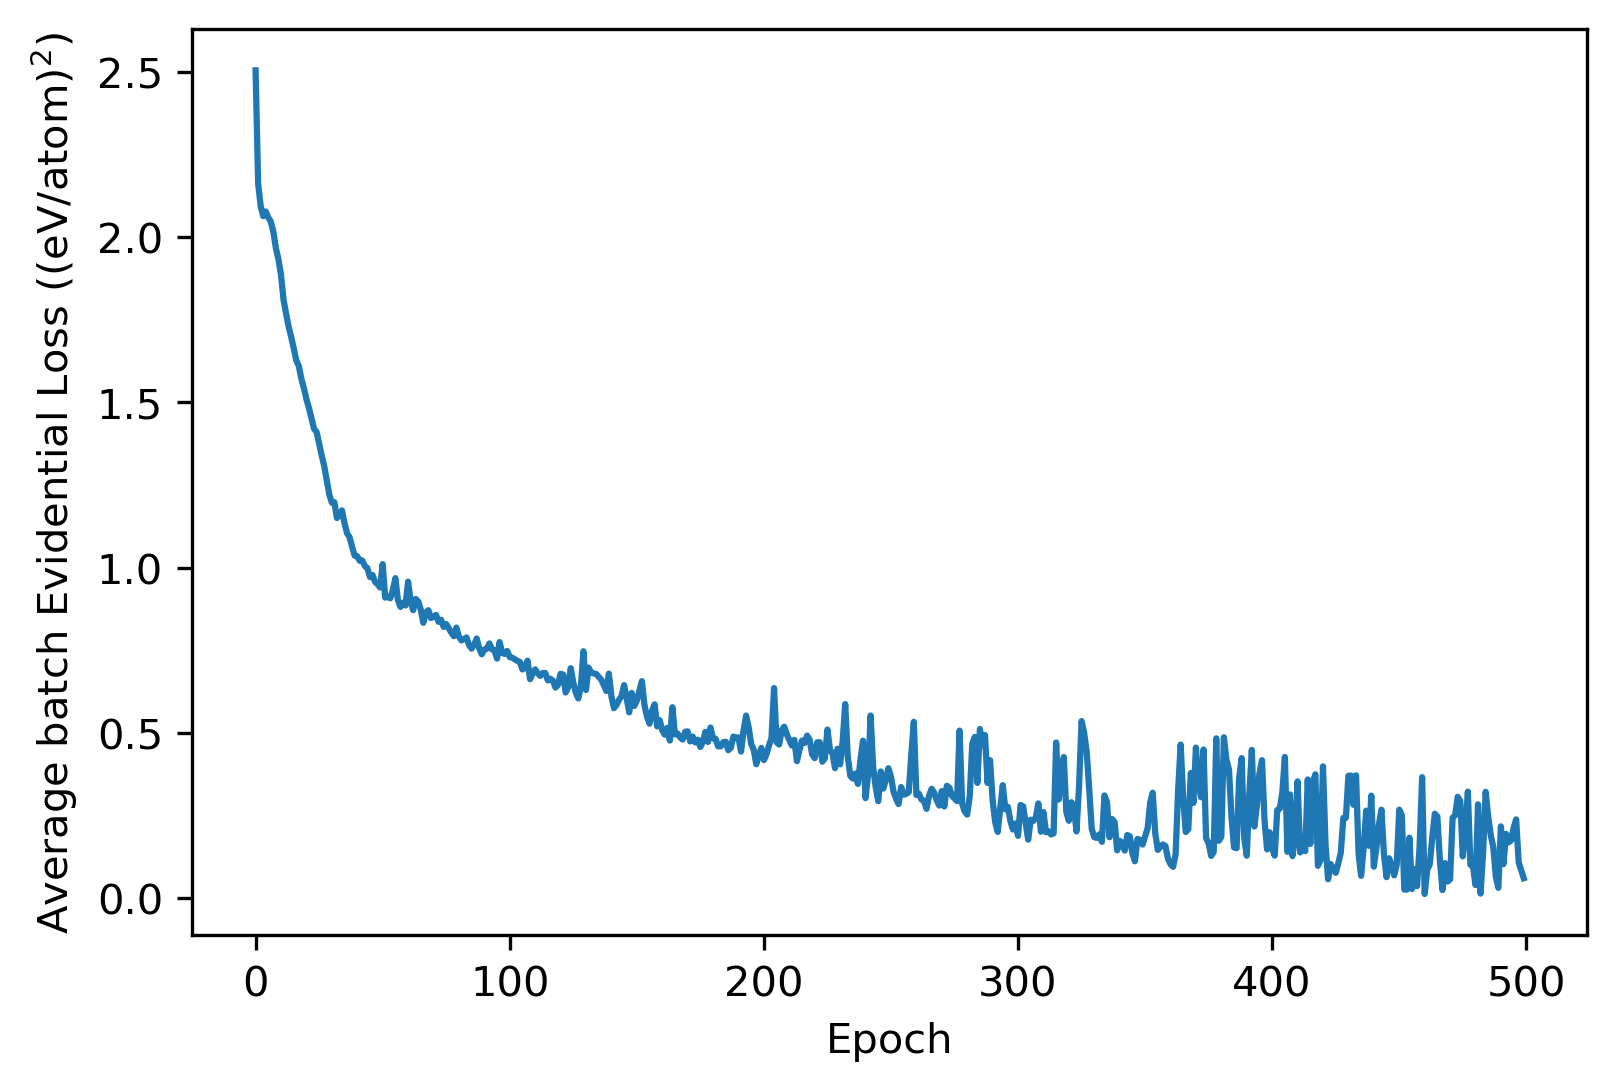

In [9]:
# Make training, Validation sets
train_set, val_set = torch.utils.data.random_split(
    data, [len(data) - 150, 150], generator=torch.Generator().manual_seed(0)
)

# Train CGCNN

# Check to see if Nvidia GPU acceleration is available.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Instantiate the CGCNN model.
# Store the CGCNN model math operations on the CPU or Nvidia GPU, depending on what is available.
model = CGCNN(device=device).to(device)
# Check the model architecture to make sure it is correct.
print(model)

# Adam Optimizer is defined here.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Set the model into training mode! Ensures that gradient calculations are being properly performed.
model.train()

# Empty list to store the losses from the evidential regression loss function.
losses = []

# Number of epochs we want to train for.
numEpochs = 500

# These kwargs (i.e., 'keyword arguments') are passed to the PyTorch dataloader.
# The PyTorch dataloader accepts a dataset and feeds data to the model in a systematic way
# for training/validation/testing/etc.
# Using a dataloader is part of the PyTorch design philosophy for performing machine learning experiments.

# First, we set the number of workers (i.e., 'num_workers')
# This is a CPU-specific parameter that, at least in a casual sense, determines how many open processes
# the computer will create to feed data into the model. More workers means more processes, which means
# a higher throughput of data to the model.
# A good rule of thumb is num_workers = # of CPU cores, but one has to benchmark to be sure.
# Using too many workers can create too much logistical overhead for the computer, thus ultimately being slower.
# Here, we set num_workers = 0, which is a special designation. It casually means load data to the model
# at a rate that is automatically needed.

# Next, we set 'pin_memory' to true. There are different types of memory (e.g., RAM versus solid state storage).
# 'Pin memory' is a type of 'static memory' or fixed memory, as opposed to 'dynamic memory' like paging.
# Using static memory can often make accessing data a faster process, which we care about!
kwargs = {"num_workers": 0, "pin_memory": True} if use_cuda else {}

# For each epoch,
for epoch in range(numEpochs):
    new_losses = []
    loader = DataLoader(train_set, batch_size=10, **kwargs)
    for batch_ndx, sample in enumerate(loader):
        sample = sample.to(device)
        optimizer.zero_grad()
        outputs = model(sample)
        # print(outputs)
        # Calculating evidential loss
        loss = EvidentialRegression(sample.y, outputs, coeff=1e-2)

        new_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    losses.append(np.mean(new_losses))
    print("Epoch: {}| Average batch Evidential Loss: {}".format(epoch, losses[epoch]))

modelSaveStr = "DER_CGCNN_GasPy_Dataset_" + str(numEpochs) + "Epochs.pt"
torch.save(model.state_dict(), modelSaveStr)

plt.plot(range(numEpochs), losses)
plt.xlabel("Epoch")
plt.ylabel(r"Average batch Evidential Loss ((eV/atom)$^2$)")

## Now that we trained and saved the model, let's evaluate the model's predictive performance.

/home/cameron/anaconda3/envs/ocp-models/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Root mean squared error: 0.3502512851455985
Mean absolute error: 0.22483281791210175


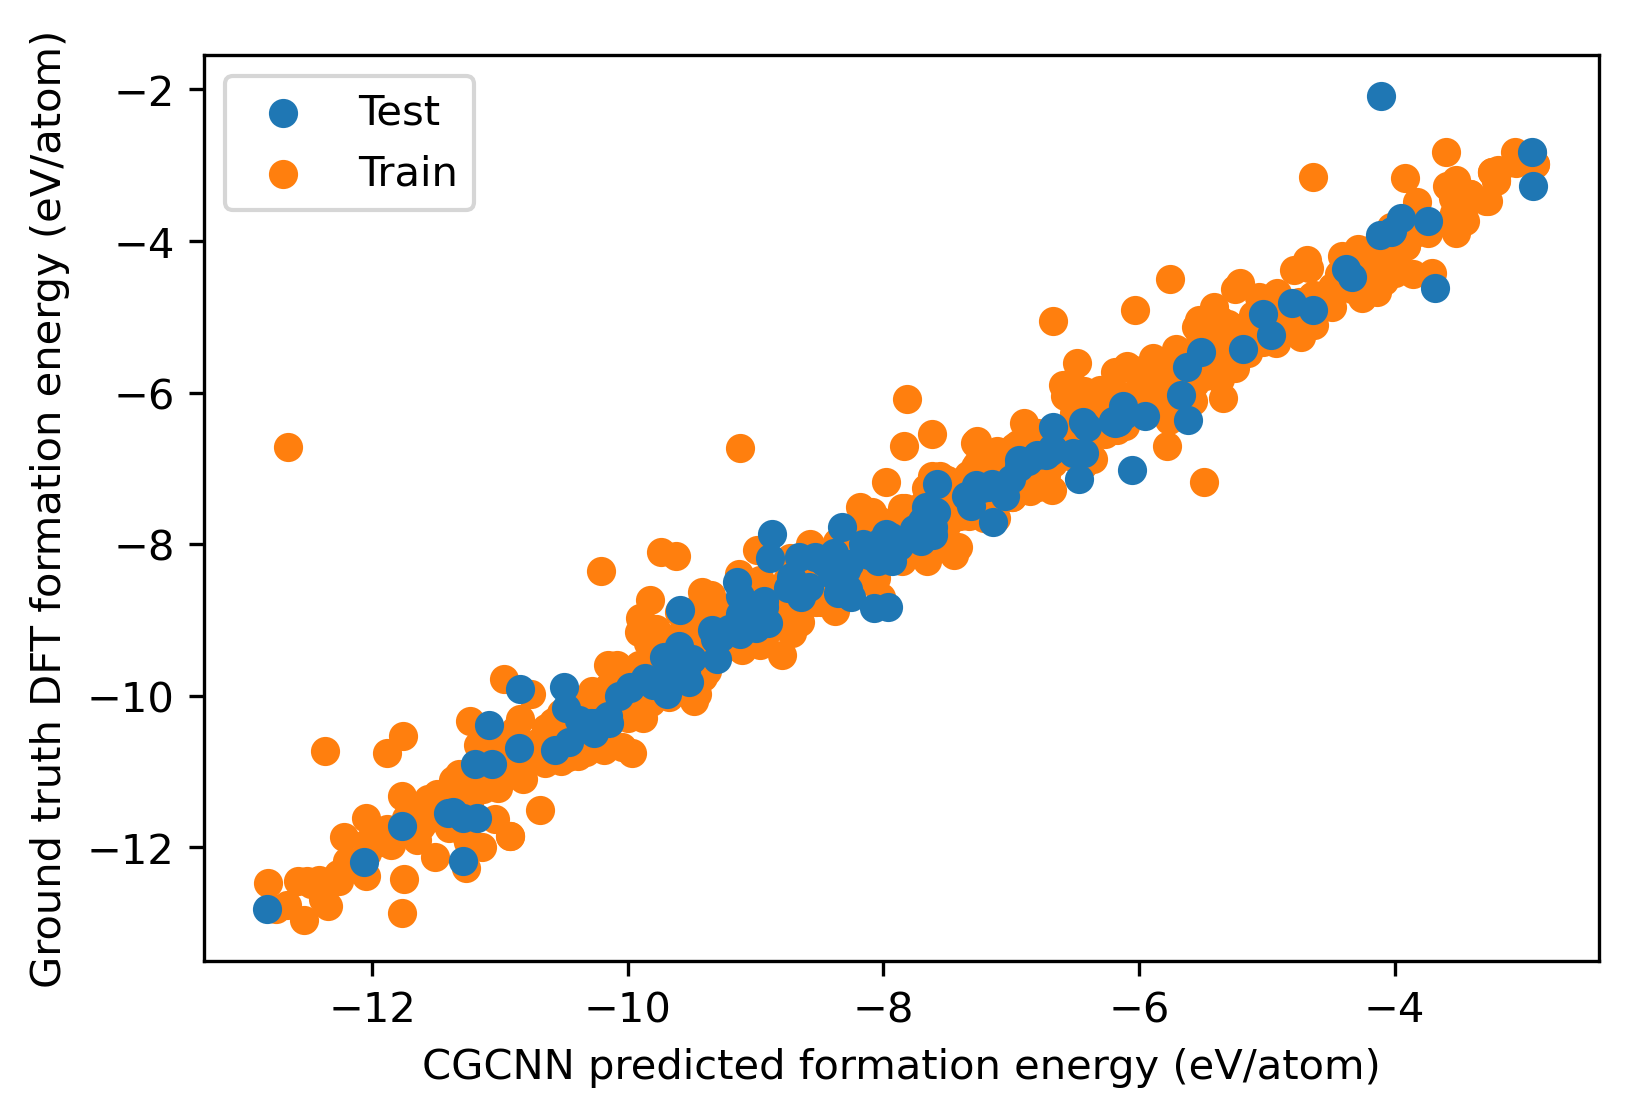

In [67]:
model = CGCNN(device=device).to(device)
model.load_state_dict(torch.load(modelSaveStr))
model.eval()

train_set, val_set = torch.utils.data.random_split(
    data, [len(data) - 150, 150], generator=torch.Generator().manual_seed(0)
)

val_set = DataLoader(val_set, batch_size=150, **kwargs)
for batch_ndx, sample in enumerate(val_set):
    sample = sample.to(device)
    pred = model(sample).cpu()
    sample = sample.cpu()

    mse = mean_squared_error(pred[:, 0].detach().numpy(), sample.y.detach().numpy())
    mae = mean_absolute_error(pred[:, 0].detach().numpy(), sample.y.detach().numpy())

    # Take each mini-batch prediction set and combine them via concatenation to get the total prediction set.
    if batch_ndx != 0:
        # Make Predictions
        pred = torch.cat((previousPred, pred), dim=0)
        previousPred = pred

        sample = torch.cat((previousSample, sample), dim=0)
        previousSample = sample

plt.scatter(
    pred[:, 0].detach().numpy(), sample.y.detach().numpy(), zorder=5, label="Test"
)


loader = DataLoader(train_set, batch_size=len(train_set.dataset))

for batch_ndx, sampleTrain in enumerate(loader):
    sampleTrain = sampleTrain.to(device)
    predTrain = model(sampleTrain).cpu()
    sampleTrain = sampleTrain.cpu()
    # Take each mini-batch prediction set and combine them via concatenation to get the total prediction set.
    if batch_ndx != 0:
        # Make Predictions
        predTrain = torch.cat((previousPredTrain, predTrain), dim=0)
        previousPredTrain = predTrain

        sampleTrain = torch.cat((previousSampleTrain, sampleTrain), dim=0)
        previousSampleTrain = sampleTrain

plt.scatter(
    predTrain[:, 0].detach().numpy(), sampleTrain.y.detach().numpy(), label="Train"
)

plt.xlabel("CGCNN predicted formation energy (eV/atom)")
plt.ylabel("Ground truth DFT formation energy (eV/atom)")
plt.legend()
print("Root mean squared error: {}".format(np.mean(mse**0.5)))
print("Mean absolute error: {}".format(np.mean(mae)))